In [141]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Analysing the 2015/2016 Premier League season with the [Dixon & Coles (1997)](http://www.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf) model

A brief exploration of the 2015/2016 season using the Dixon and Coles approach. In this model, the probability distribution of goals scored by the home team (X) and away team (Y) are modelled as Poisson processes that are independent (except in low scoring games, where a correlation parameter is introduced)

`p(X=x, Y=y) = Poisson(lambda) * Poisson(mu) * tau(x,y,lambda,mu)`

the tau function introduces correlations between home and away goals when the scoreline is (0,0) (1,0) (0,1) or (1,1). It has one free parameter, rho. The rates of the two distributions are 

`lambda = alpha_home * beta_away * gamma`

`mu = alpha_away * beta_home` 

where alpha_i is an attacking index, characterising how effective a team is in attack, beta_i is a defending index, characterising how effectively a team defends, and gamma is a home advantage parameter. The rate at which the home team scores goals is set by how well they attack (`alpha_home`), how well their opponents defend (`beta_away`) and the advantage they gain from playing at home (`gamma`). The reasoning is similar for the away team, except that they gain no home advantage. For the Premier League (PL) there are 20 teams, so that there are 20 `alpha` parameters, 20 `beta` parameters, one `gamma` and one `rho`, so that there are 42 parameters in total. I fit the model to data using a maximum likelihood approach. 


In [39]:
#Load the relevant modules and set up environment

from __future__ import division, print_function
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set_style()
import dixoncoles as d 
import pandas as pd 
%matplotlib inline

data,teams = d.load_and_preprocess();

Let's look at the data:

In [17]:
data.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,BookiesHomeWin,BookiesDraw,BookiesAwayWin,Gameweek
Date,,,,,,,,
2015-08-08,0,10,0,1,0.500000,0.277778,0.250000,1
2015-08-08,1,13,2,2,0.735294,0.200000,0.090909,1
2015-08-08,2,15,2,2,0.588235,0.256410,0.181818,1
2015-08-08,3,12,4,2,0.512821,0.285714,0.230947,1
2015-08-08,4,14,1,0,0.606061,0.250000,0.166667,1


The table is indexed by the date on which a match occurred. The 'HomeTeam' column is numerical, but we can see that the numbers correspond to teams in the PL:

In [33]:
print('teams[0] = '+ teams[0])

teams[0] = Bournemouth


e.g. a value of 0 in the 'HomeTeam' or 'AwayTeam' corresponds to Bournemouth playing in that match. I did this for convenience when fitting the model to data. There are then columns for the goals scored by either team. I have also included the bookies probabilities for a home win, a draw and an away win for each match. Finally, there is a column 'Gameweek', which groups the matches into calendar weeks. There are 36 gameweeks. Before diving into the Dixon and Coles model, lets do some basic data analysis.

In [22]:
num_home_wins = len(data[data['HomeGoals']>data['AwayGoals']])
num_away_wins = len(data[data['HomeGoals']<data['AwayGoals']])
num_draws = len(data[data['HomeGoals'] == data['AwayGoals']])
print("fraction of home wins: {0:.2f}".format(num_home_wins/(num_home_wins+num_away_wins+num_draws)))
print("fraction of away wins: {0:.2f}".format(num_away_wins/(num_home_wins+num_away_wins+num_draws)))
print("fraction of draws: {0:.2f}".format(num_draws/(num_home_wins+num_away_wins+num_draws)))

fraction of home wins: 0.41
fraction of away wins: 0.31
fraction of draws: 0.28


So home team wins are the most common outcome, 41% of the matches ended in this way. Away team wins and draws are similar in their prevalence, both at about 30%. This explains why Dixon & Coles introduced the home advantage parameter.

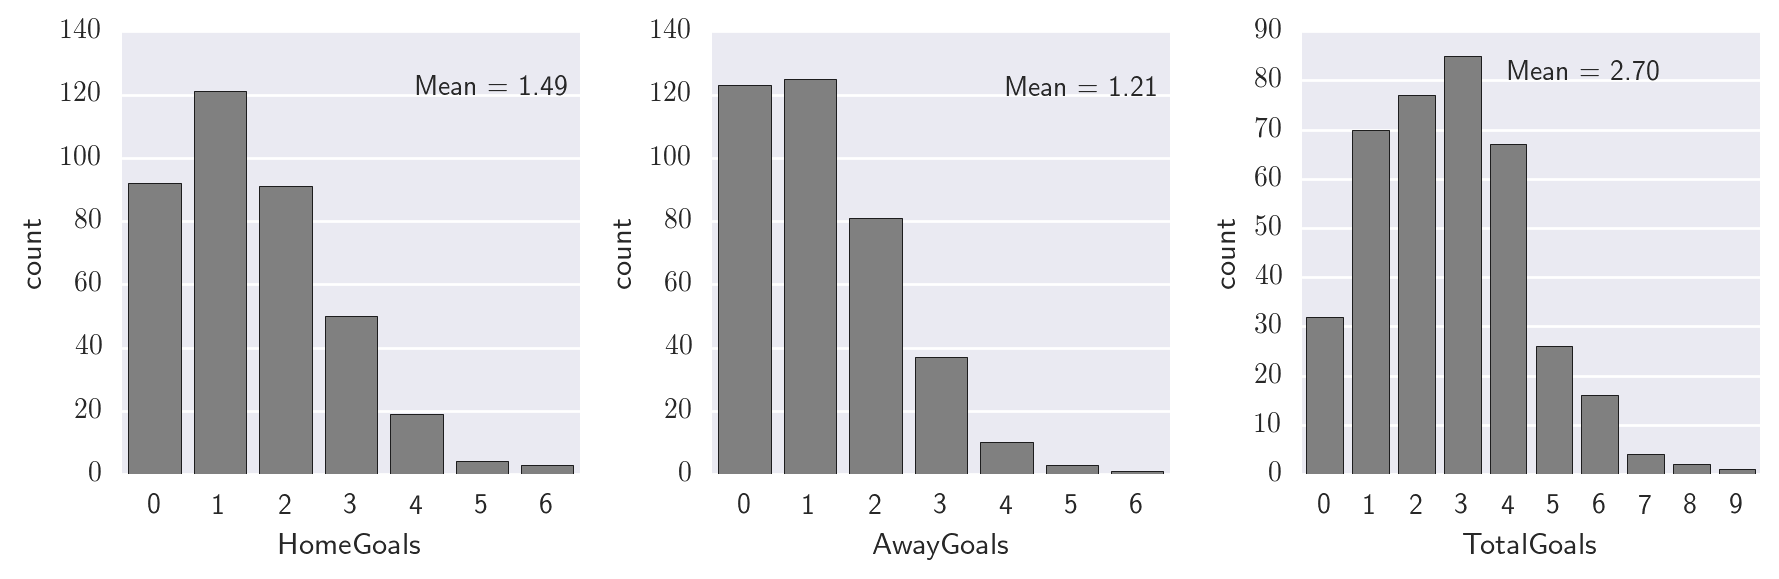

In [18]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
sns.countplot(data['HomeGoals'],ax=ax[0],color='0.5')
sns.countplot(data['AwayGoals'],ax=ax[1],color='0.5')
data.loc[:,'TotalGoals'] = pd.Series(data['HomeGoals']+data['AwayGoals'])
sns.countplot(data['TotalGoals'],ax=ax[2],color='0.5');
ax[0].text(4,120,"Mean = {0:.2f}".format(data['HomeGoals'].mean()))
ax[1].text(4,120,"Mean = {0:.2f}".format(data['AwayGoals'].mean()))
ax[2].text(4,80,"Mean = {0:.2f}".format(data['TotalGoals'].mean()));

So a mean of 2.7 goals were scored per game, and on average the home team scored 0.28 more goals than the away team. The away team is quite likely not to score any goals.

## Form throughout the season

Let's have a go at fitting the model now. First, I will fit the model to each gameweek in turn using a sliding window, so that the previous twenty gameweeks are considered in the fit. I only consider twenty previous gameweeks because intuitively I expect more recent games to be more relevant to current form. For gameweeks < 20, I simply use all the previous gameweeks. I fit the model using the SLSQP method in scipy, and add the constraint that 

sum(alpha) = n_teams

i.e. the attack indices must add up to the number of teams. Such a constraint is necessary because otherwise there is a degeneracy in the likelihood. I also added the constraints on the correlation parameter, rho, that are detailed in Dixon & Coles' paper. Once I have fit the model, we can look at how the parameters for each team vary throughout the season.

In [3]:
alpha,beta,gamma,rho = d.fit_model_season(data,window=20)
alpha = pd.DataFrame(alpha).rename(columns=lambda x: teams[x])
beta = pd.DataFrame(beta).rename(columns=lambda x: teams[x])

Now we can plot the form of the teams throughout the season. First, let's plot the attacking indices.

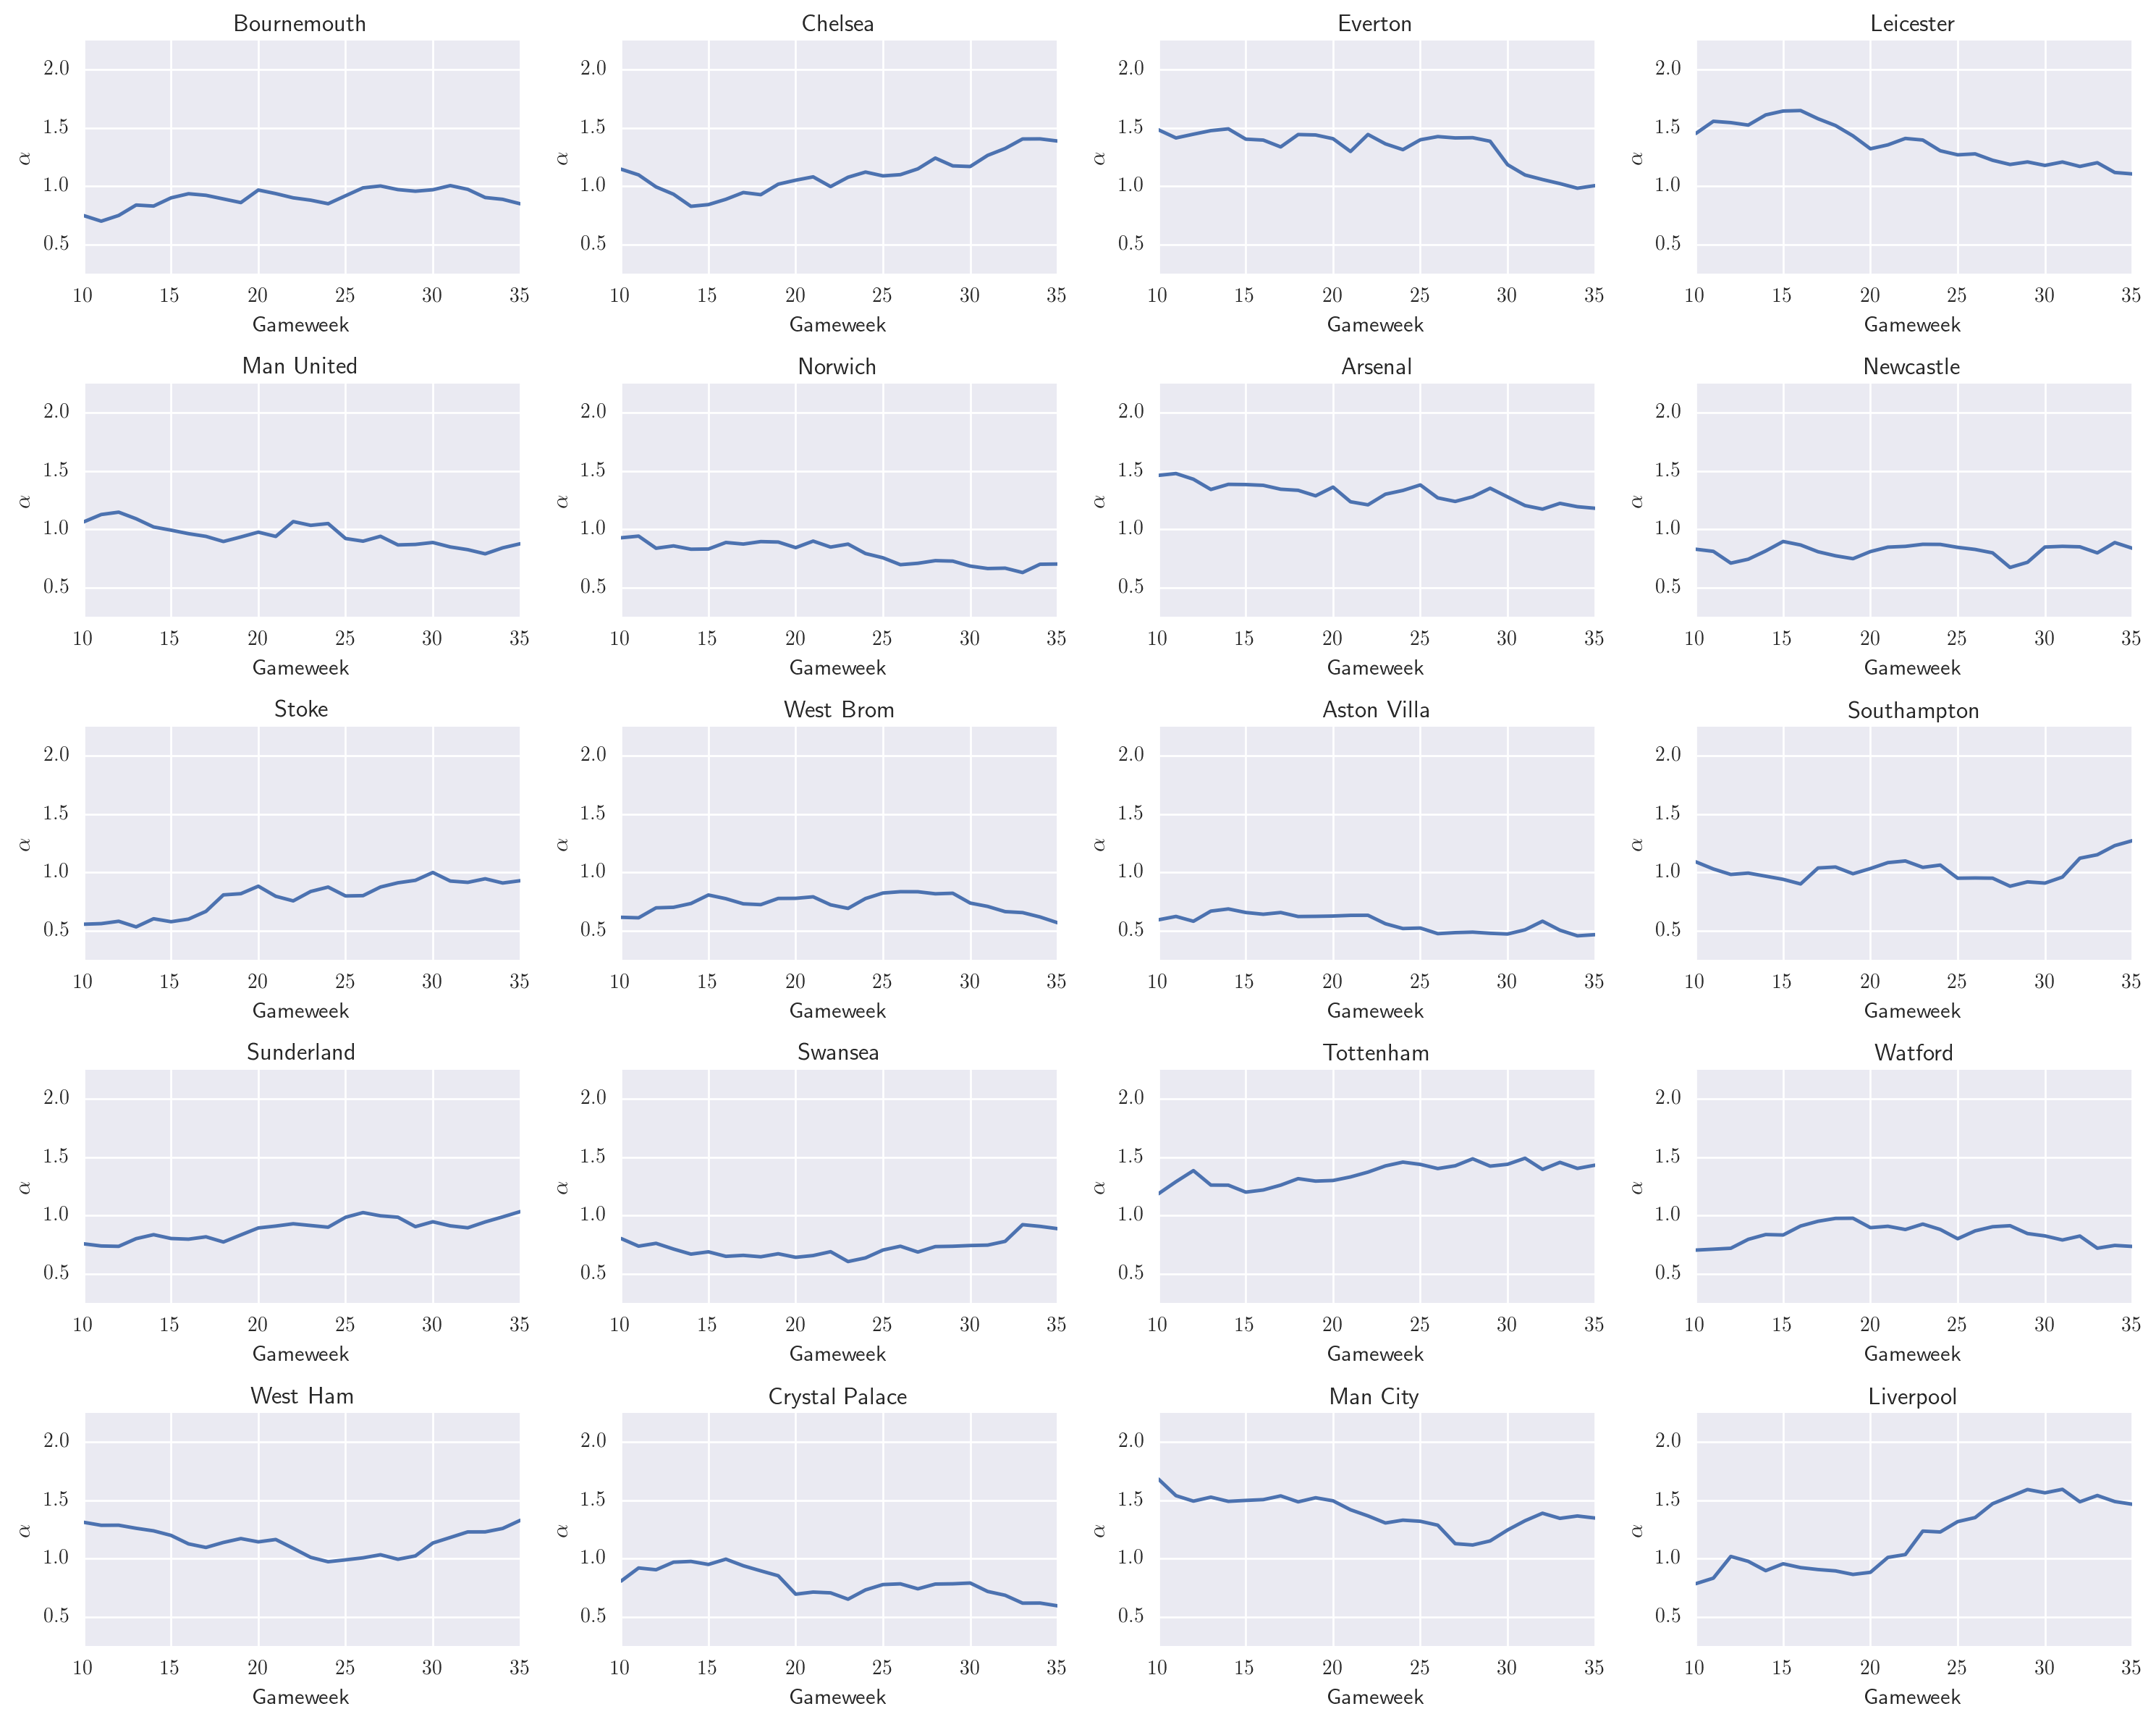

In [5]:
fig,ax = plt.subplots(5,4,figsize=(15,12))
for i,team in enumerate(teams):
    np.ravel(ax)[i].plot(alpha[team][10:])
    np.ravel(ax)[i].set_ylim((0.25,2.25))
    np.ravel(ax)[i].set_title(team)
    np.ravel(ax)[i].set_xlabel("Gameweek")
    np.ravel(ax)[i].set_ylabel("$\\alpha$");
    

For the most part, the attacking indices of the teams don't change a great deal. This is likely because I considered twenty previous gameweeks, which is a good chunk of the season. Unfortunately, stable estimates of the model parameters require a relatively large window. Nonetheless, there are some trends to check out. First, the relative sizes of the attacking indices are meaningful: teams like Tottenham and Arsenal have high attacking indices, about 1.5, whereas struggling teams like Aston Villa are significantly lower, at 0.5. Interestingly, Leicester seem to get poorer at attacking throughout the season despite winning the league. Chelsea improve as the season progresses, as do Liverpool. Let's see how the defensive indices look.

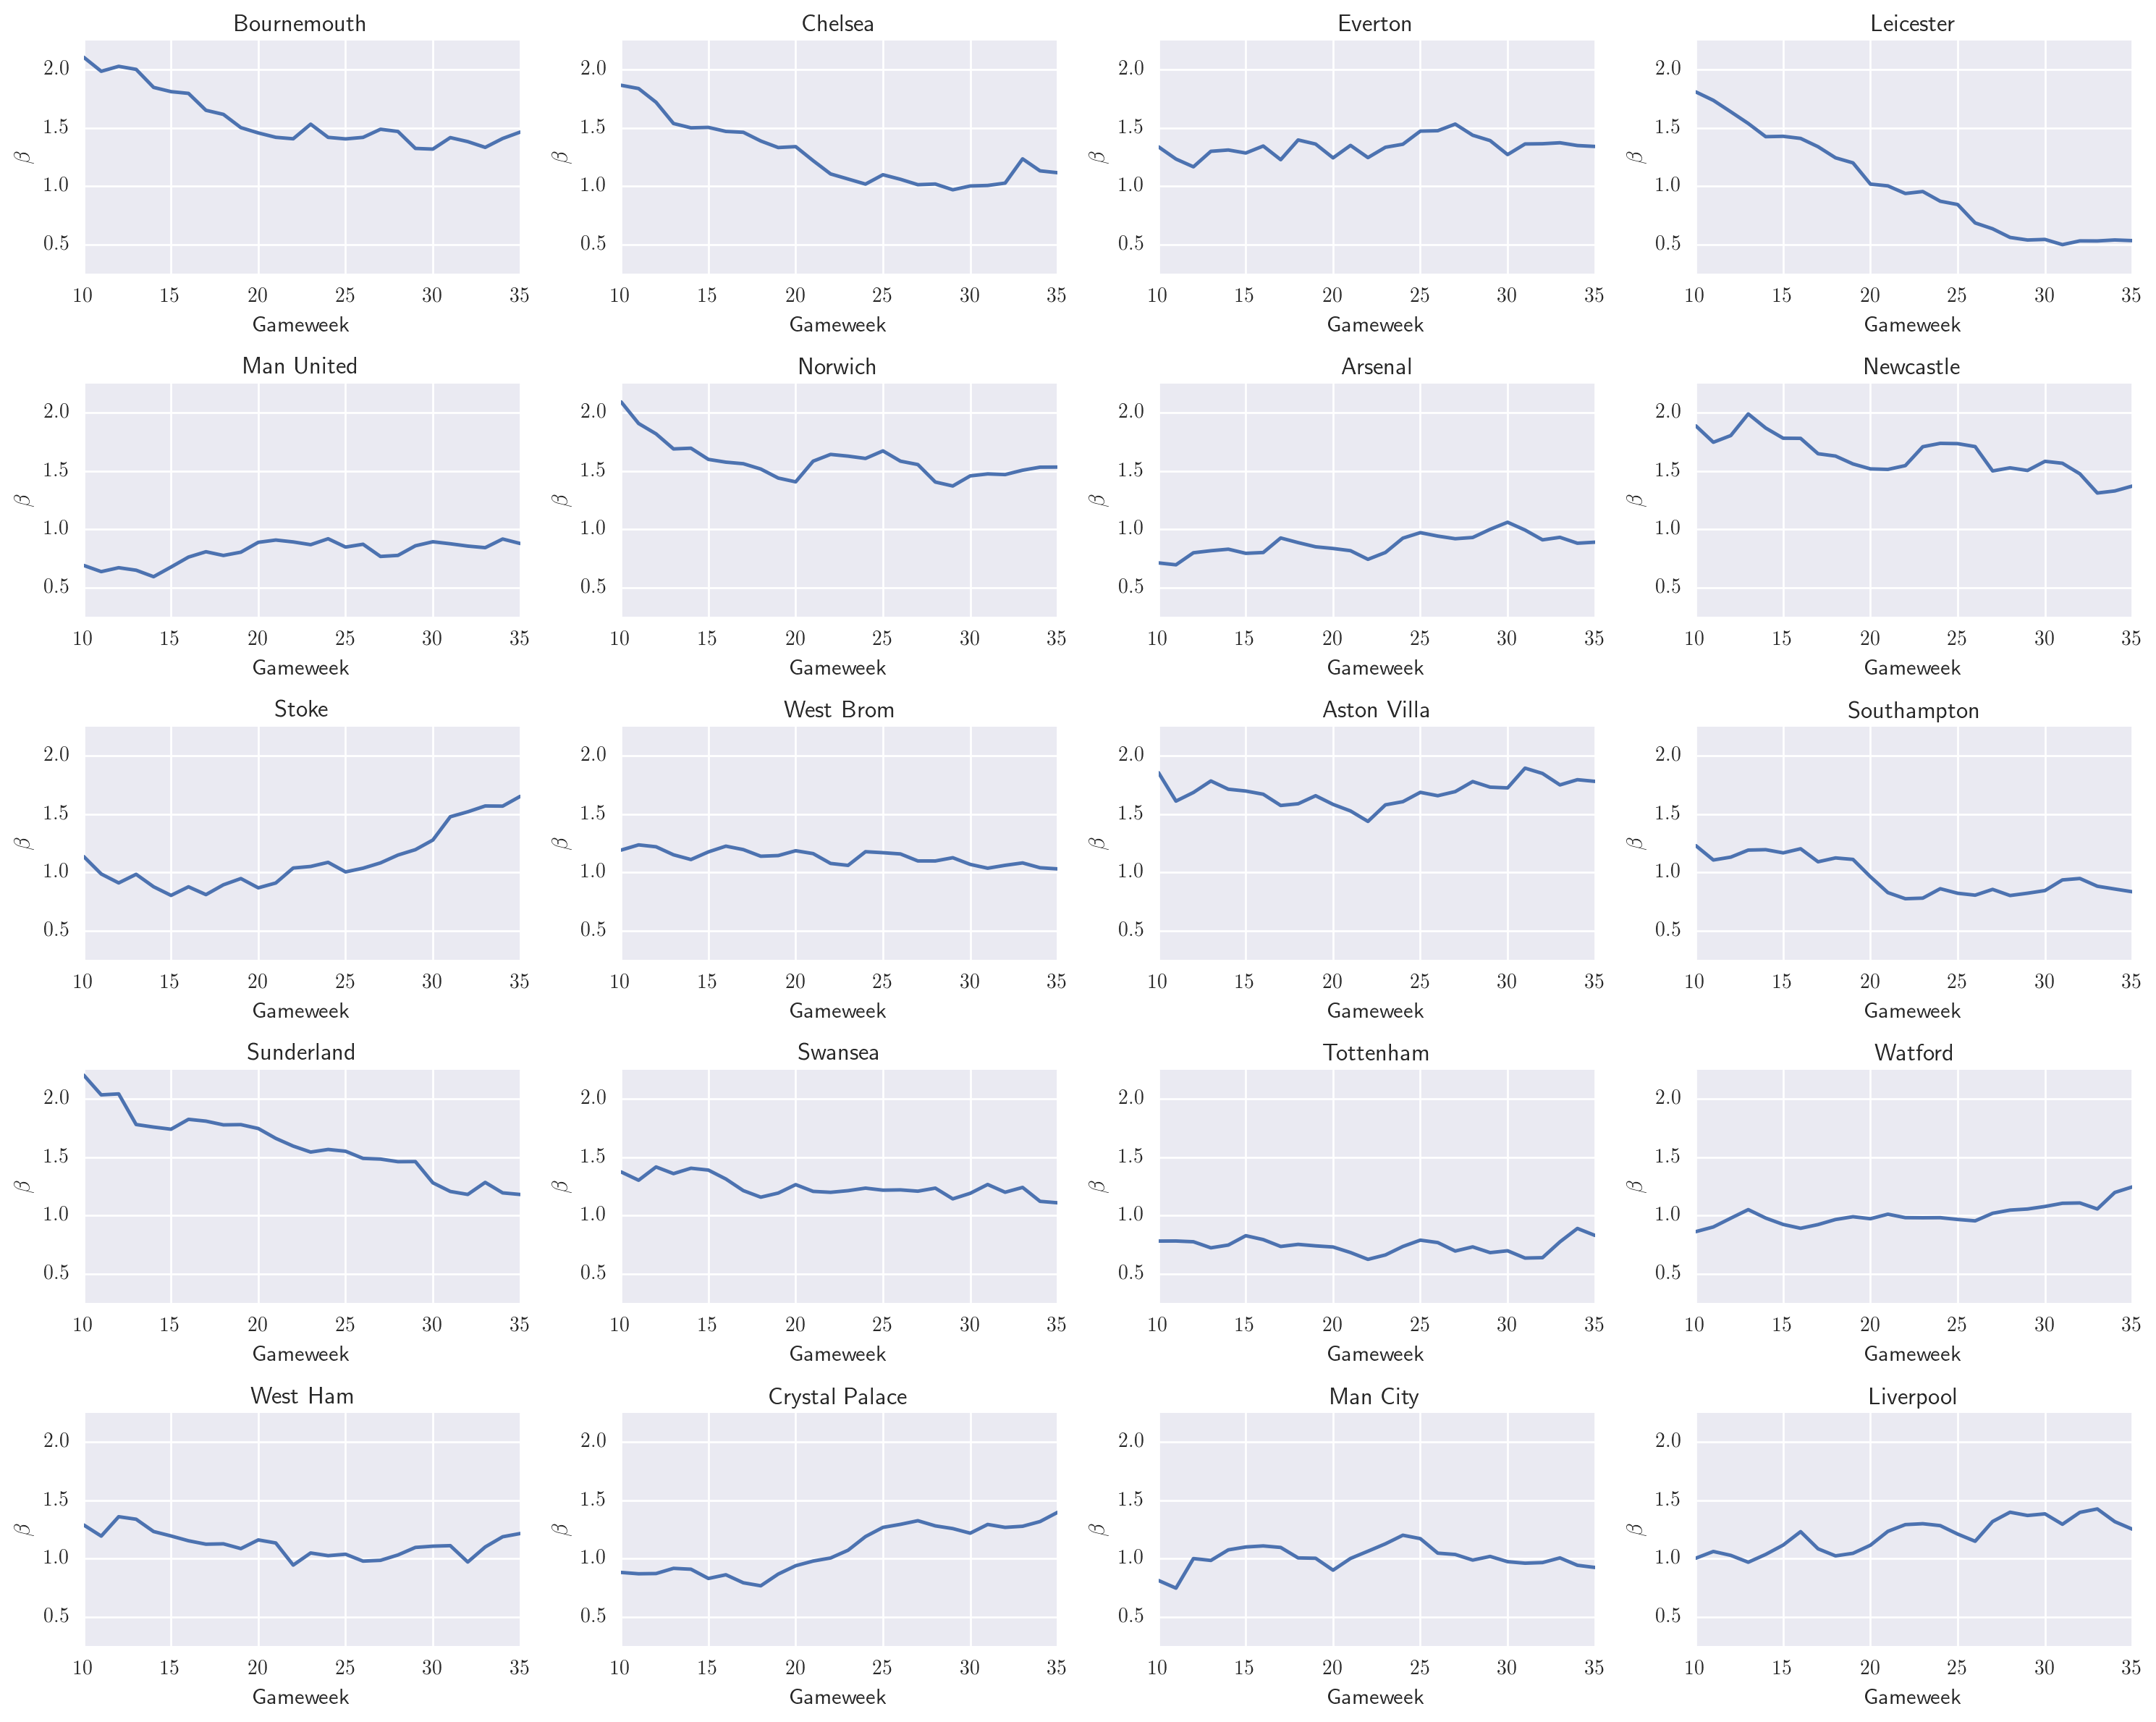

In [6]:
fig,ax = plt.subplots(5,4,figsize=(15,12))
for i,team in enumerate(teams):
    np.ravel(ax)[i].plot(beta[team][10:])
    np.ravel(ax)[i].set_ylim((0.25,2.25))
    np.ravel(ax)[i].set_title(team)
    np.ravel(ax)[i].set_xlabel("Gameweek")
    np.ravel(ax)[i].set_ylabel("$\\beta$");
    

Note that a good team will have a *low* defense index. The defensive indices seem to vary a little more than the attacking ones. The range is between about 0.5 and 2. Tottenham, Man United, Arsenal and Leicester have the best defensive indices. Leicester's plummets as the season progresses - their defense became more and more solid. Again, we see Chelsea improve with time after their bad start.

It is interesting to see the variations in a team's ability to attack and defend, but it is hard to interpret in terms of their overall form. Leicester's attacking index actually fell throughout the season, but this was offset by a decrease in their defensive index. Hence, let's define a *form index*

form = alpha / beta

This has the right behaviour. A good team has a large alpha and a small beta, so a large form index. A poor team has a low alpha and a high beta, so a low form index. Lets plot this value for each team throughout the season.

In [9]:
form = pd.DataFrame(alpha.values/beta.values).rename(columns=lambda x: teams[x])

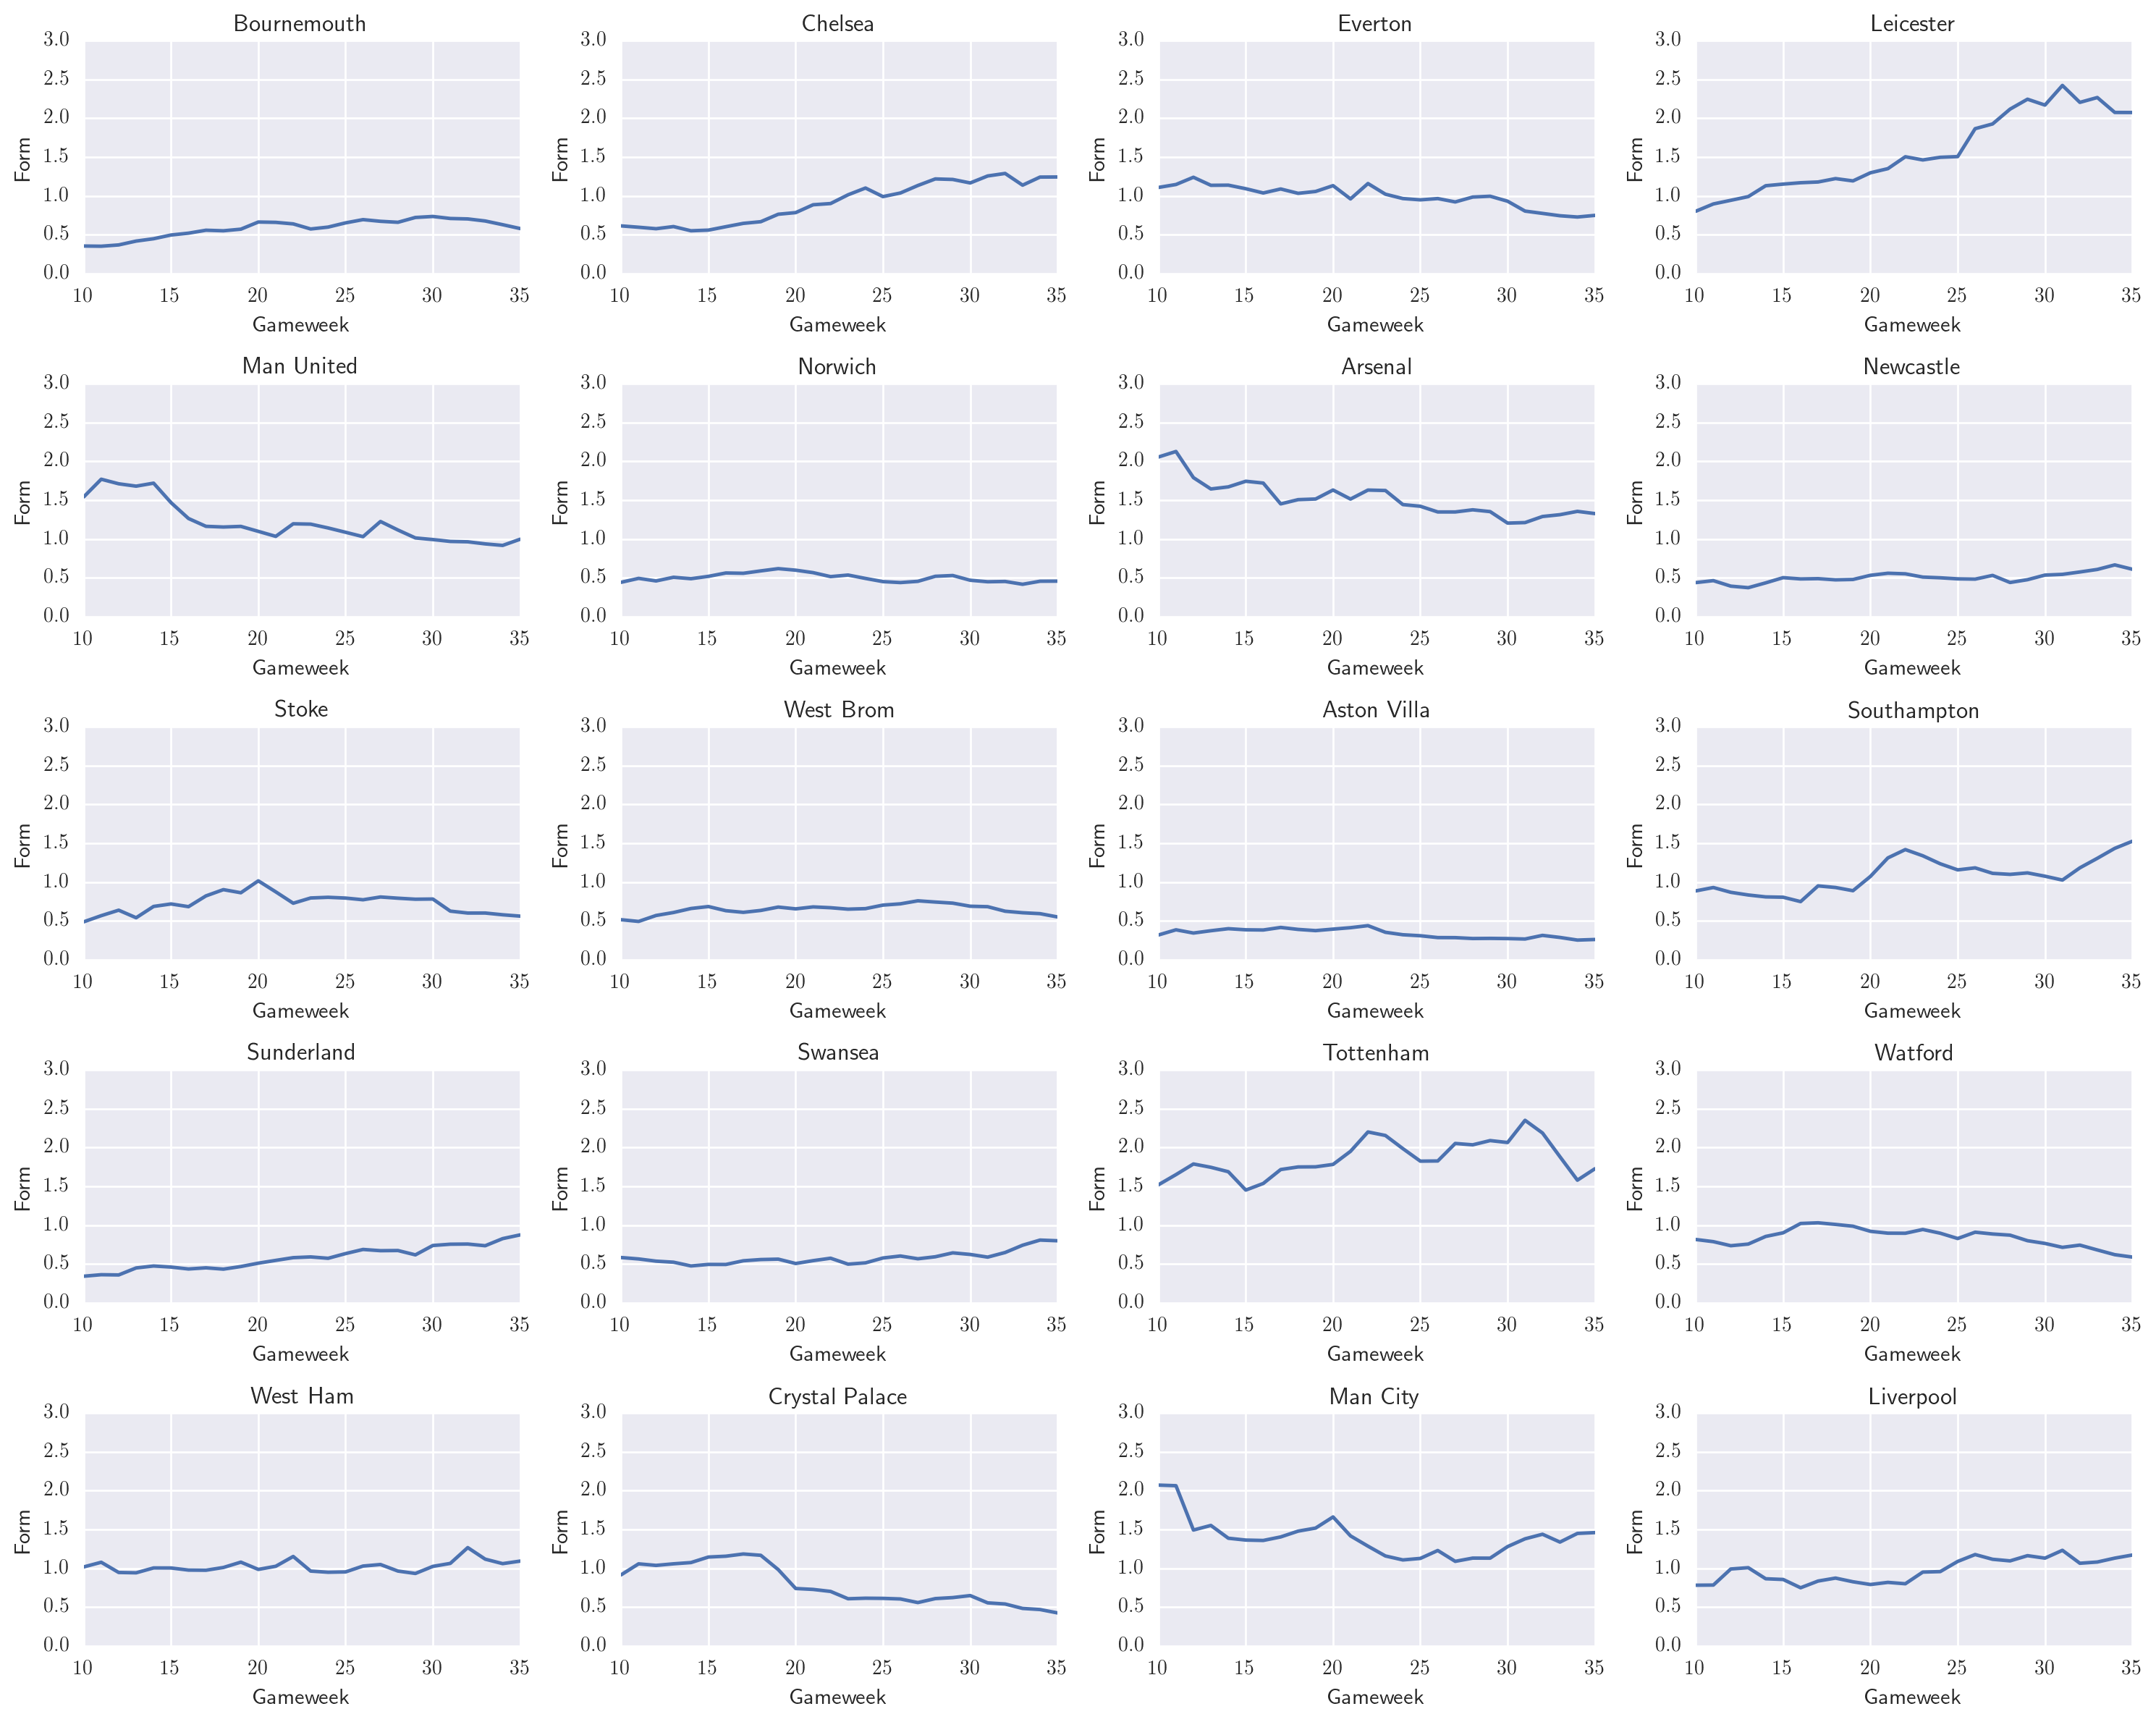

In [10]:
fig,ax = plt.subplots(5,4,figsize=(15,12))
for i,team in enumerate(teams):
    np.ravel(ax)[i].plot(form[team][10:])
    np.ravel(ax)[i].set_ylim((0.,3.))
    np.ravel(ax)[i].set_title(team)
    np.ravel(ax)[i].set_xlabel("Gameweek")
    np.ravel(ax)[i].set_ylabel("Form");

The form index seems to roughly reflect intuition about the quality of the teams. Tottenham's is ~ 2 for much of the season, whereas we see Leicester's rocket up as the season goes on. Based on these plots, you might guess that Tottenham won the league, so clearly the form index isn't perfect (although Leicester's form index is larger than Tottenham's at the end of the season). Villa's is the lowest, at < 0.5 consistently, Arsenal's form declines from 2 down to about 1.3, reflecting a typical season for the Gunners: a promising start, followed by a relatively disappointing second half of the season.

Finally, lets look at the other two parameters, gamma and rho.

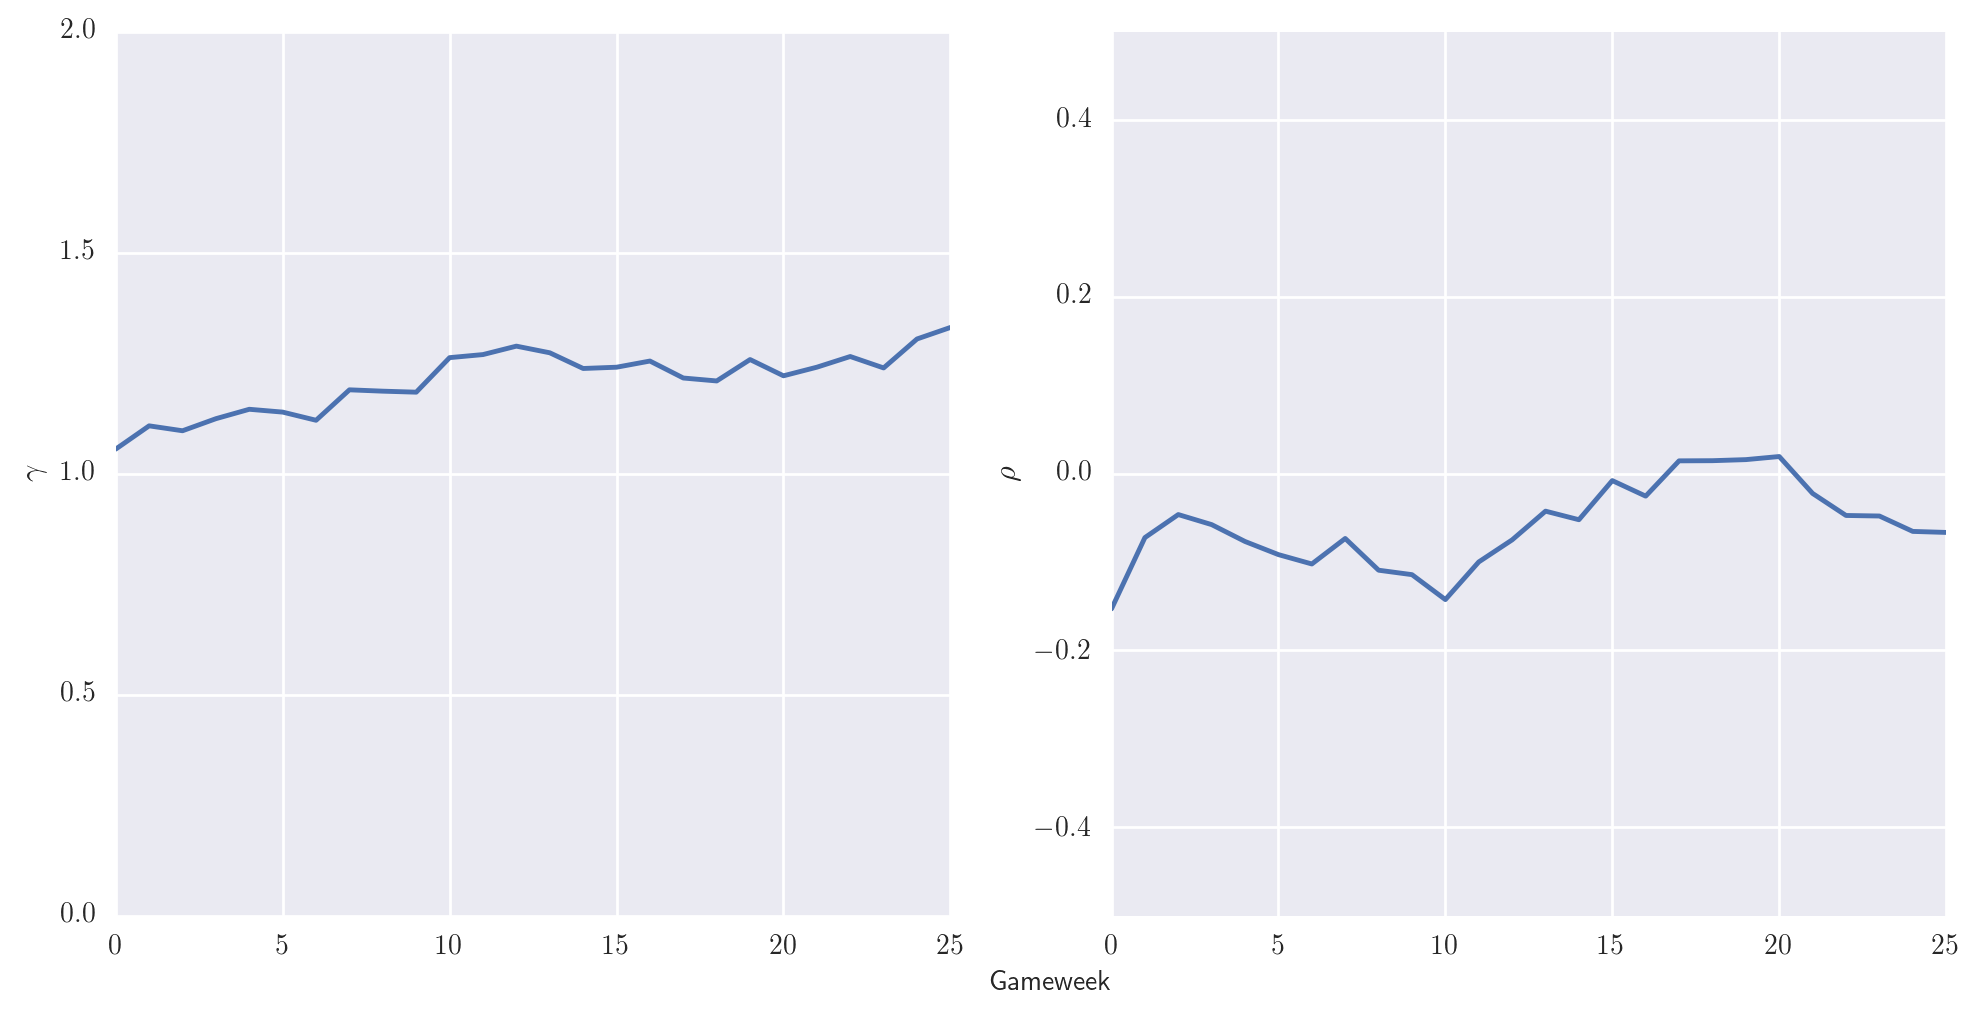

In [12]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(gamma[10:])
ax[1].plot(rho[10:])
fig.text(0.5,0.,"Gameweek")
ax[0].set_ylabel("$\\gamma$")
ax[1].set_ylabel("$\\rho$")
ax[0].set_ylim((0.,2.))
ax[1].set_ylim((-0.5,0.5));

So we see that the home advantage factor doesn't vary a huge amount, sitting between about 1.1 and 1.4 throughout the season. The correlation parameter is small, and usually negative. It's tricky to interpret exactly what that means.

## How does past form influence present form?

Dixon & Coles advocated an approach to fitting the model where more weight is given to recent matches. They modified the log-likelihood of the model so that the log-likelihood for a given match is weighted by 

exp(- zeta * T)

where T is the number of half-weeks between the date at which predictions are required and a match in the past, and zeta is a parameter than controls the severity of the fall-off with time. zeta = 0 would mean placing equal importance on matches regardless of when they occurred. 

In order to choose zeta, Dixon & Coles tested the predictive power of the model throughout the season when different values of zeta were selected. On a given date, they fit the model using all of the data prior to that date. They then calculated the probabilities of home wins, away wins and draws on the given date. The best value of zeta will maximise the probability of the true outcome (i.e. the model will have a large probability of a draw if the match ended in a draw). Hence, one steps through the season and fits the model on each game-day to matches that happened before that game day, and then stores the probability of a home win, away win and draw for all the matches on that day. Eventually, one has a table of these probabilities for all of the matches in the season, and the predictive log-likelihood can be computed. This procedure is repeated for different values of zeta, and the value that maximises the predictive log-likelihood is chosen.

I'll now do the same thing, except I will work with time differences in days rather than half-weeks.

In [2]:
%%capture
zeta,lnprob = d.compute_zeta(data);

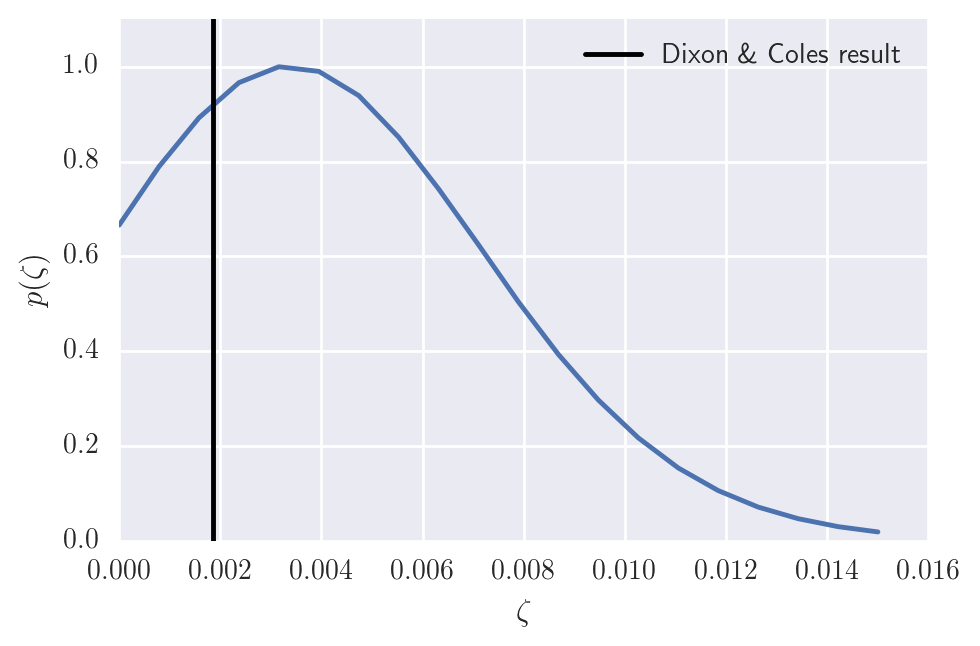

In [13]:
fig,ax = plt.subplots()
ax.plot(zeta,np.exp(lnprob-np.max(lnprob)))
ax.set_ylim(0.,1.1)
ax.axvline(0.0065/3.5,c='k',label='Dixon \\& Coles result')
ax.legend(loc='upper right')
ax.set_xlabel("$\\zeta$")
ax.set_ylabel("$p(\\zeta)$");

In [14]:
print("Timescale: {0:.2f} days".format(1./zeta[np.argmax(lnprob)]))
print("Dixon & Coles result: {0:.2f} days".format(1./(0.0065/3.5)))

Timescale: 316.67 days
Dixon & Coles result: 538.46 days


In this model, the timescale over which current form becomes less dependent on previous form is almost a year. In the original Dixon and Coles model, it is still longer. The reason for this is likely that the Dixon & Coles model presumably works best when there have been many different match-ups in the league: when each team has played most of the other teams. This allows the model to correctly evaluate the relative strengths of each team. In order to do this, most of the season is required when fitting the model. I think that this result is indicative that a good predictive model of football outcomes should be able to utilise recent information rather better than the Dixon & Coles model can.

## How well does the model predict results?

I'll now investigate how well the model actually works. First, let's do something simple. If the model is fit to the season, using the optimal value of zeta, how well does the form index defined earlier predict the positions of teams in the league? Evidently, this isn't quite the right test to do, because the form index reflects *current* form, whereas league position is a function of form throughout the season. On the other hand, the size of zeta suggests that the form index takes matches from the start of the season nearly as seriously as those at the end,.

In [13]:
alpha_final,beta_final,gamma_final,rho_final = d.compute_parameters(data)
form_final = alpha_final/beta_final;

In [14]:
predicted_positions = pd.Series(teams[np.argsort(form_final)[::-1]],index=np.arange(1,21))
print("Predicted positions of teams at the end of the season: \n")
print(predicted_positions)

Predicted positions of teams at the end of the season: 

1          Leicester
2          Tottenham
3            Arsenal
4           Man City
5        Southampton
6         Man United
7          Liverpool
8           West Ham
9            Chelsea
10           Everton
11        Sunderland
12           Swansea
13           Watford
14         Newcastle
15             Stoke
16    Crystal Palace
17         West Brom
18       Bournemouth
19           Norwich
20       Aston Villa
dtype: object


In [43]:
true_positions = pd.Series(np.array(['Leicester','Arsenal','Tottenham','Man City', 'Man United', 'Southampton',\
                              'West Ham', 'Liverpool', 'Stoke', 'Chelsea', 'Everton', 'Swansea', 'Watford',\
                              'West Brom', 'Crystal Palace', 'Bournemouth','Sunderland', 'Newcastle', 'Norwich', \
                              'Aston Villa']), index = np.arange(1,21))
print("True positions of teams at the end of the season: \n")
print(true_positions)

True positions of teams at the end of the season: 

1          Leicester
2            Arsenal
3          Tottenham
4           Man City
5         Man United
6        Southampton
7           West Ham
8          Liverpool
9              Stoke
10           Chelsea
11           Everton
12           Swansea
13           Watford
14         West Brom
15    Crystal Palace
16       Bournemouth
17        Sunderland
18         Newcastle
19           Norwich
20       Aston Villa
dtype: object


At first glance, the model seems to have done a decent job. Let's check by plotting the difference between the teams' true positions and their real positions.

In [53]:
differences = np.zeros(20)
for i,team in enumerate(teams):
    true_pos = true_positions[true_positions==team].index[0]
    pred_pos = predicted_positions[predicted_positions==team].index[0]
    differences[i] = pred_pos - true_pos

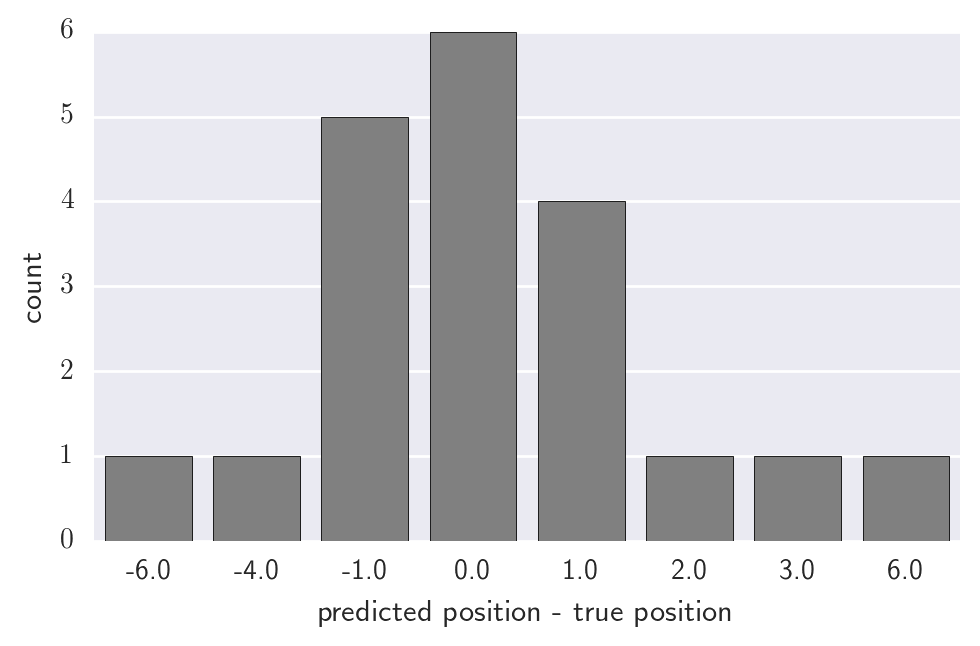

In [56]:
sns.countplot(differences,color='0.5')
plt.xlabel("predicted position - true position");

We can see that for 15 of the 20 teams, the position is either correct or only off by one. Let's compare this to a random permutation of the team names, so we can check how good this result actually is.

In [62]:
random_positions = pd.Series(np.random.permutation(teams),index=np.arange(1,21))
random_differences = np.zeros(20)
for i,team in enumerate(teams):
    true_pos = true_positions[true_positions==team].index[0]
    rand_pos = random_positions[random_positions==team].index[0]
    random_differences[i] = rand_pos - true_pos

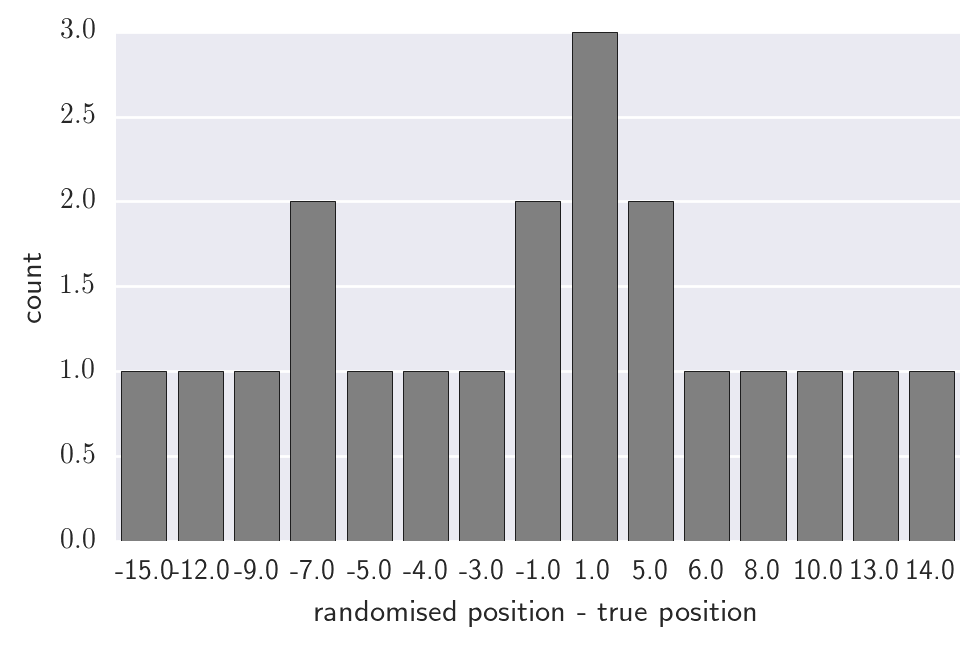

In [63]:
sns.countplot(random_differences,color='0.5')
plt.xlabel("randomised position - true position");

Lets now look at the results when we try to predict the outcome of individual matches. I'll use the sliding window model again for convenience, as the results don't seem very sensitive to the choice of weightings of previous gameweeks. Here I choose to look at gameweek 33, and fit the model to the twenty previous gameweeks.

In [19]:
n=32
a_w,b_w,g_w,r_w = d.fit_model_up_to_round(data,gameweek=n,window=20) 
gw_w = data.loc[data['Gameweek']==n+1,:]
home,draw,away = np.zeros(len(gw_w)),np.zeros(len(gw_w)),np.zeros(len(gw_w))
for i in np.arange(len(gw_w)):
    home[i],draw[i],away[i] = d.result_probabilities(a_w[gw_w['HomeTeam'][i]],a_w[gw_w['AwayTeam'][i]],\
                                                    b_w[gw_w['HomeTeam'][i]],b_w[gw_w['AwayTeam'][i]],\
                                                    g_w,r_w)
x = gw_w['HomeGoals'].values
y = gw_w['AwayGoals'].values
result = np.ones(len(gw_w)).astype(int)
result[x>y] = 0
result[x<y] = 2

pred_result = np.array([np.argmax([home[i],draw[i],away[i]]) for i in np.arange(len(gw_w))])

result_df = pd.DataFrame(np.vstack((gw_w['HomeTeam'].values,gw_w['AwayTeam'].values,home,draw,away,result,pred_result)).T,\
                         columns=['HomeTeam','AwayTeam', 'HomeWinProb','DrawProb','AwayWinProb','Result','PredResult'])

confusion_matrix = np.zeros((3,3))
for i in np.arange(3):
    for j in np.arange(3):
        confusion_matrix[i,j] = len(result_df[(result_df['Result']==i)&(result_df['PredResult']==j)])


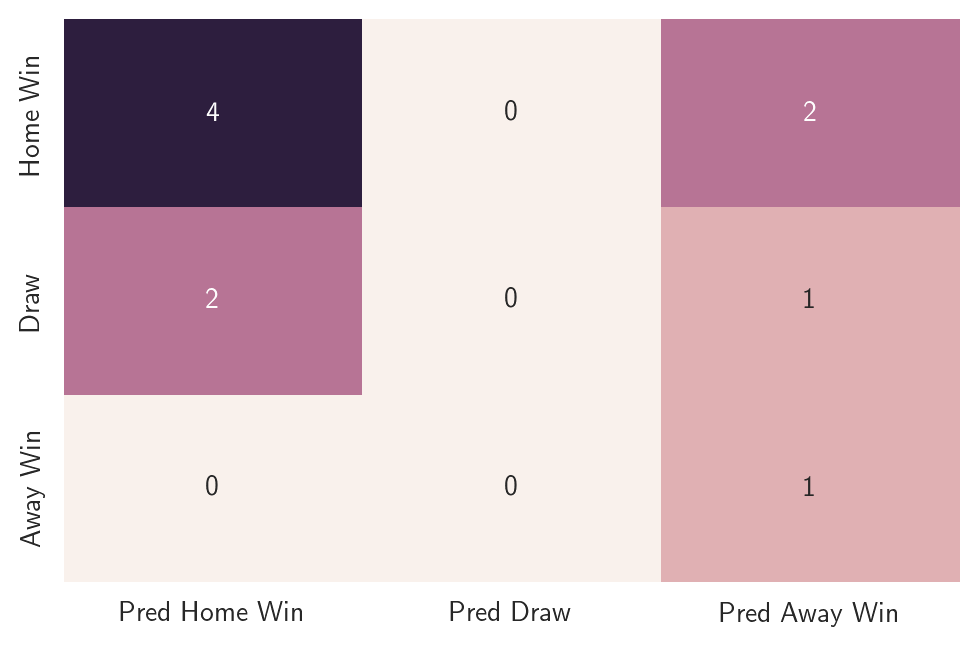

In [20]:
sns.heatmap(confusion_matrix,annot=True,cbar=False,xticklabels=['Pred Home Win','Pred Draw','Pred Away Win']\
            ,yticklabels=['Home Win','Draw','Away Win']);

The confusion matrix shows how accurately the model is predicting the outcome of games. A cell in a given row and column shows the number of games with the outcome given by the row, and the predicted outcome given by the column. Ideally, we would want all the games to lie on the diagonal, so that home wins are always predicted as home wins etc. Sadly, this isn't the case for our model. The single away win in gameweek 33 is correctly forecast by the model, and four of the six home wins are correctly forecast too. However, there are three draws and the model predicts zero. In fact, the model almost *never* thinks that a draw is the most likely result. Let's look at the cases where the model was wrong to learn a bit more about why it is failing.

In [24]:
hometeams = teams[result_df['HomeTeam'][(result_df['Result']==0)&(result_df['PredResult']==2)].astype(int)]
awayteams = teams[result_df['AwayTeam'][(result_df['Result']==0)&(result_df['PredResult']==2)].astype(int)]

In [26]:
print("Mispredicted "+hometeams[0]+" vs. "+awayteams[0]+" (Southampton won, predicted Man City would win)")
print("Mispredicted "+hometeams[1]+" vs. "+awayteams[1]+" (Swansea won, predicted Liverpool would win)")

Mispredicted Southampton vs. Man City (Southampton won, predicted Man City would win)
Mispredicted Swansea vs. Liverpool (Swansea won, predicted Liverpool would win)


Ok, so Southampton managed to beat Man City and Swansea defeated Liverpool that week. The model predicted wins for Man City and Liverpool, which perhaps isn't unexpected. What about the draws that were mispredicted?

In [27]:
hometeams = teams[result_df['HomeTeam'][(result_df['Result']==1)].astype(int)]
awayteams = teams[result_df['AwayTeam'][(result_df['Result']==1)].astype(int)]

In [29]:
print("Mispredicted "+hometeams[0]+" vs. "+awayteams[0])
print("Mispredicted "+hometeams[1]+" vs. "+awayteams[1])
print("Mispredicted "+hometeams[2]+" vs. "+awayteams[2])

Mispredicted Tottenham vs. West Brom
Mispredicted Stoke vs. Sunderland
Mispredicted Man United vs. Leicester


Tottenham failed to beat West Brom at home, which is probably surprising given that they finished third and fourteenth respectively. Stoke and Sunderland are a bit closer together in the league. Man United vs. Leicester seems like the most obvious candidate for a draw.

On reflection, it is unsurprising that the model never assigns the largest probability to a draw - if every configuration of home and away goals between 0 and 3 were equally likely, then the probability of of a draw is 1/4, whereas the probability of a home (or away) win is 3/8. So, even if the teams are relatively evenly matched, a draw is still not the most likely result. This result remains true if gamma = 1. We have gamma ~ 1.2, so that home advantage is present but not enormous - the logic above is still applicable. 

## Comparison of model probabilities with bookies' predictions

I'll now compare the probabilities of different results with those from Bet365. In the original Dixon & Coles paper, they carried out such a comparison to see if their model could be used to bet effectively. I'll compute the probabilities for all of matches after the first 20 game days using the optimal value of zeta from above. For each game day, I fit the model to all previous game days in the season.

In [40]:
data_odds = d.calculate_odds(data,zeta=0.003)
data_odds = data_odds.dropna()

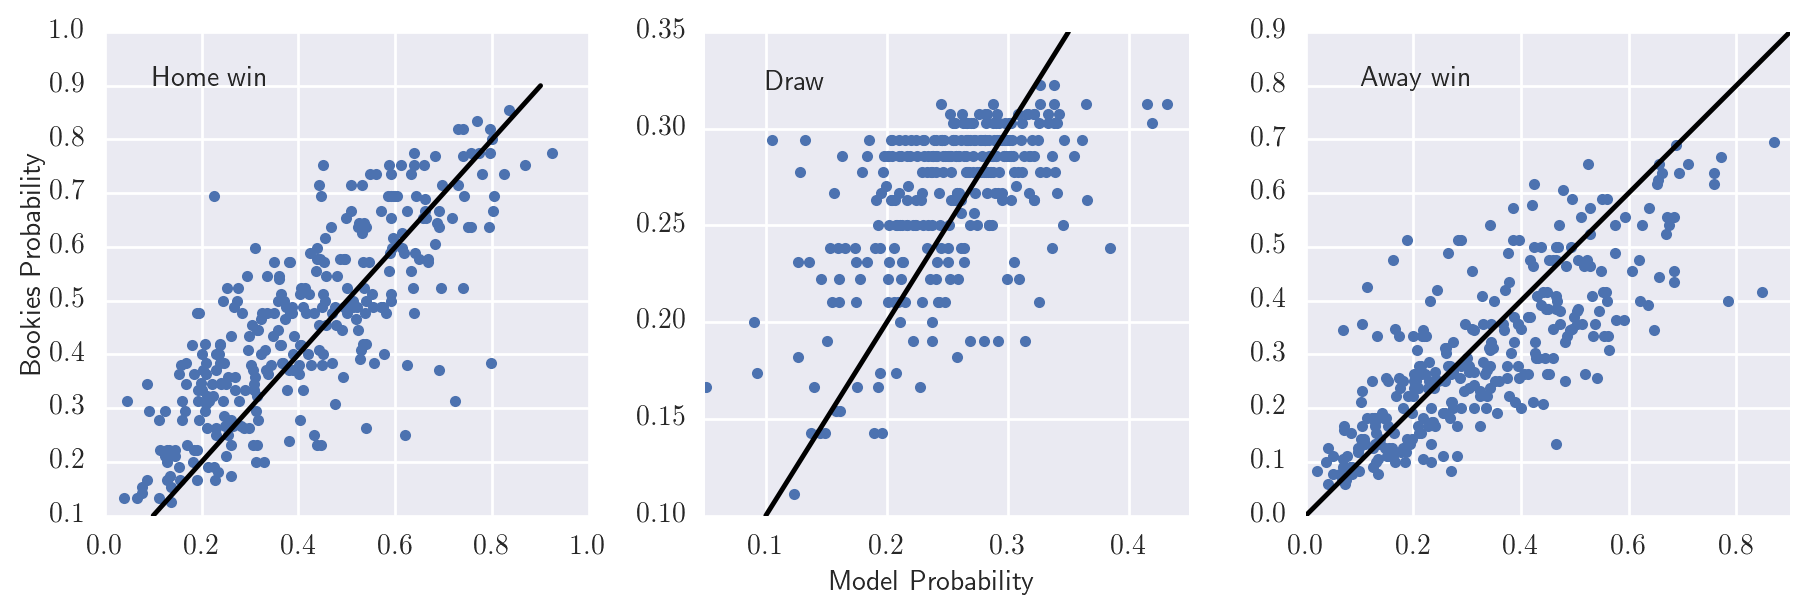

In [138]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
x0 = np.linspace(0.1,0.9)
x1 = np.linspace(0.1,0.35)
x2 = np.linspace(0.,0.9)
ax[0].plot(data_odds['ProbHomeWin'],data_odds['BookiesHomeWin'],'o',ms=4)
ax[0].plot(x0,x0,c='k')
ax[1].plot(data_odds['ProbDraw'],data_odds['BookiesDraw'],'o',ms=4)
ax[1].plot(x1,x1,c='k')
ax[2].plot(data_odds['ProbAwayWin'],data_odds['BookiesAwayWin'],'o',ms=4)
ax[2].plot(x2,x2,c='k')

ax[1].xaxis.set_ticks([0.1,0.2,0.3,0.4])
ax[2].xaxis.set_ticks([0.,0.2,0.4,0.6,0.8])

ax[0].text(0.1,0.9,'Home win')
ax[1].text(0.1,0.32,'Draw')
ax[2].text(0.1,0.8,'Away win')

fig.text(0.45,0.,'Model Probability')
fig.text(0.,0.7,'Bookies Probability',rotation=90);

So far, so good. The model seems to be in pretty good agreement with the bookies' odds. The black lines are y=x, and the points seem to roughly scatter either side of this line. Both the bookies and the model usually predict a value of about 0.25 for a draw, without much scatter. The home win and away win probabilities exhibit much more scatter. The model predictions for these outcomes tend to be a little lower than the bookies' predictions. The fact that the model probabilities an the bookies' probabilities are not identical means that, if the model turns out to be more accurate than the bookies' probabilities, then a betting strategy could be created that has positive expected returns.

An important point here is that the bookies' probabilities won't add up to one. We can see this:

In [35]:
print("Mean sum of bookies' probabilities = {0:.2f}".format(np.mean(data['BookiesHomeWin']+data['BookiesDraw']\
                                                                   +data['BookiesAwayWin'])))

Mean sum of bookies' probabilities = 1.03


This is called the 'take', or the 'overround'. The bookies compute their predictions, and then they artificially increase the outcome probabilities. In an ideal world (for the bookies), they then make a fractional profit equal to the overround. In the data here, the overround is 0.03, corresponding to a 3% profit for the bookies. The reality will be more complicated than this, but we should bear this in mind when comparing the model to the bookies' odds.

In [43]:
bookies_sum = data_odds['BookiesHomeWin']+data_odds['BookiesDraw']+data_odds['BookiesAwayWin']
data_odds.loc[:,'ScaledBookiesHomeWin'] = pd.Series(data_odds['BookiesHomeWin'].values/bookies_sum.values\
                                                    ,index=data_odds.index)
data_odds.loc[:,'ScaledBookiesDraw'] = pd.Series(data_odds['BookiesDraw'].values/bookies_sum.values\
                                                 ,index=data_odds.index)
data_odds.loc[:,'ScaledBookiesAwayWin'] = pd.Series(data_odds['BookiesAwayWin'].values/bookies_sum.values\
                                                    ,index=data_odds.index)

Following Dixon & Coles, we now investigate how we might use the model to construct a betting strategy. They suggest betting when

`p_model / p_bookies > r`

where `p_bookies` is the unscaled probability of a home win, draw or away win (i.e. when the sum of the probabilities is > 1). `r` is a ratio > 1 (Dixon & Coles find `r > 1.1` could lead to positive expected returns). I'll now test and see if the model is more accurate than the Bet365 models by bootstrapping the data and then placing bets of equal size on all matches where `p_model(home_win)/p_bookies(home_win) > r`, and I'll try different values of `r`. 

In [127]:
n=500
r = np.linspace(1.,1.2,10)
bs_returns = np.zeros((len(r),n))

for i,ri in enumerate(r):
    for j in np.arange(n):
        bootstrap = data_odds.sample(n=len(data_odds),replace=True)
        bet = bootstrap[bootstrap['ProbDraw']/bootstrap['BookiesDraw'] > ri]
        returns = np.zeros(len(bet))
        returns[(bet['Result']==1).values] = (1./bet['BookiesDraw'][bet['Result']==1] - 1.)
        returns[(bet['Result']!=1).values] = -1.
        bs_returns[i,j] = np.mean(returns)

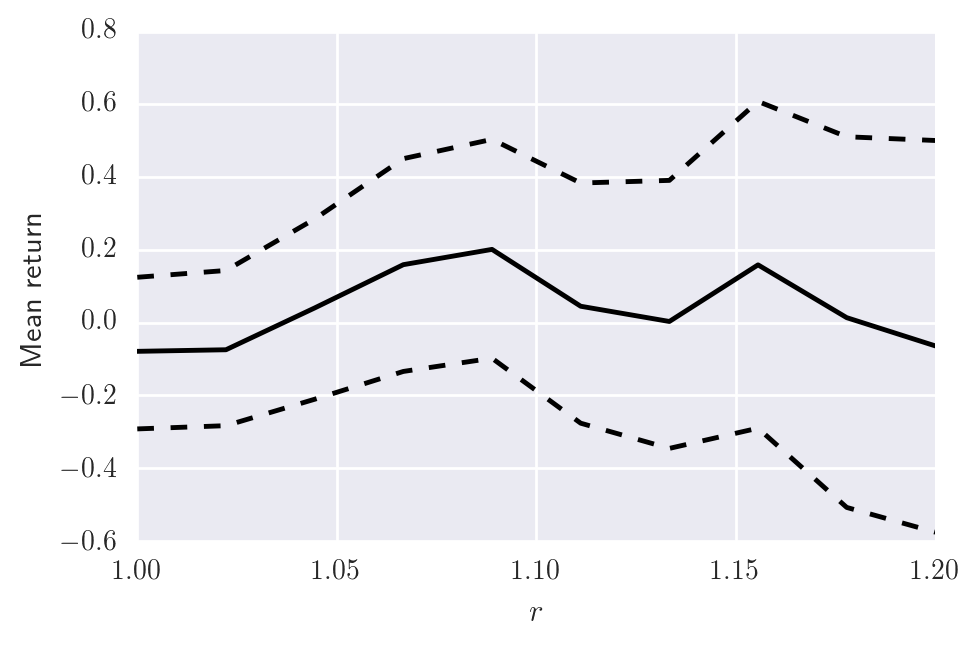

In [139]:
fig,ax = plt.subplots()
ax.plot(r,np.mean(bs_returns,axis=1),c='k')
ax.plot(r,np.percentile(bs_returns,10,axis=1),c='k',ls='--')
ax.plot(r,np.percentile(bs_returns,90,axis=1),c='k',ls='--')
ax.set_xlim((1.,1.2))
ax.set_xlabel("$r$")
ax.set_ylabel("Mean return");

So, when we try to apply the Dixon & Coles model to the 2015/16 season, it appears that it is equally or less accurate than Bet365's probabilities of match outcomes. We can see this is the case because the mean return for all values of `r` is consistent with zero (the black line is the mean, and the dashed lines are the 10 and 90 percent bootstrap intervals). This is in contrast to Dixon & Coles paper, where they find tentative evidence that at larger values of `r` will yeild positive expected returns. So, don't use this model as the basis for a betting strategy!

Out of interest, I heard somewhere that bookies tend to underestimate the probability of a draw. What would have happened if we had bet the same amount on all matches, and placed the bet on a draw?

In [130]:
n=500
draw_returns = np.zeros(n)

for j in np.arange(n):
    bootstrap = data_odds.sample(n=len(data_odds),replace=True)
    returns = np.zeros(len(bootstrap))
    returns[(bootstrap['Result']==1).values] = (1./bootstrap['BookiesDraw'][bootstrap['Result']==1] - 1.)
    returns[(bootstrap['Result']!=1).values] = -1.
    draw_returns[j] = np.mean(returns)

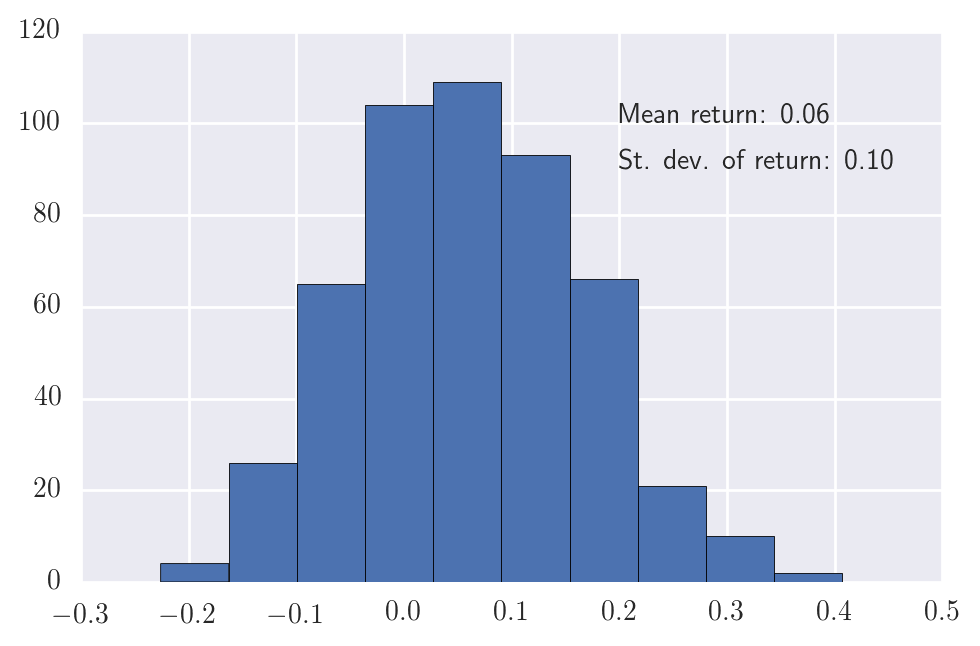

In [140]:
fig,ax = plt.subplots()
ax.hist(draw_returns)
ax.text(0.2,100,"Mean return: {0:.2f}".format(np.mean(draw_returns)))
ax.text(0.2,90,"St. dev. of return: {0:.2f}".format(np.std(draw_returns)));

So we shouldn't use this as a strategy either. The mean return is positive, at 6%, but the standard deviation across the bootstrapped samples is 10%, and so we can't say with confidence that this strategy will yeild a profit.

## Conclusions

I've investigated the classic model of Dixon & Coles in the context of the 2015/16 PL season. The model produces results that agree with intuition about the form of teams, and the probabilities that it produces are in reasonable agreement with, although less or equally accurate to, the Bet365 probabilities. The results in terms of a betting strategy are less positive than were found by Dixon & Coles in 1997, which is to be expected since the models used by betting companies have presumably become more accurate in the last twenty years. Nonetheless, the model is simple and quite effective. 

The code that I wrote to do this analysis is in this repo, in `dixoncoles.py`.